# In-Vivo Validation of PIA with Histopathology

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import normaltest, pearsonr
from termcolor import colored
import seaborn as sns
from scipy.stats import linregress


In [46]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylim(-20,20)

In [47]:
def steigers_z_test(r1, r2, n1, n2):
    """
    Performs Steiger's Z-test for two dependent correlation coefficients sharing one variable in common.

    Args:
    r1 (float): Pearson correlation coefficient for the first comparison.
    r2 (float): Pearson correlation coefficient for the second comparison.
    n1 (int): Sample size for the first comparison.
    n2 (int): Sample size for the second comparison.

    Returns:
    float: Z-score indicating the difference between the two correlation coefficients.
    float: p-value assessing the significance of the Z-score.
    """
    # Fisher Z transformation for each correlation
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)

    # Standard error for each transformed correlation
    se1 = 1 / np.sqrt(n1 - 3)
    se2 = 1 / np.sqrt(n2 - 3)

    # Standard error of the difference
    sed = np.sqrt(se1**2 + se2**2)

    # Z-score
    z = (z1 - z2) / sed

    # Two-tailed p-value
    p = 2 * (1 - stats.norm.cdf(np.abs(z)))

    return z, p

In [56]:
def calculate_mae_bias_variance(y_true, y_pred):
    """
    Calculate the Mean Absolute Error (MSE) and Bias.

    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted or estimated values.

    """
    mae = np.mean(np.abs(y_true - y_pred))
    bias = np.mean((y_pred - y_true))
    variance = np.std((y_pred - y_true))**2

    return mae, bias, variance

def compare_mae(y_true, y_pred1, y_pred2):
    """
    Compare the MSEs of two predictions and perform a paired t-test.

    Args:
    y_true (array-like): Actual values.
    y_pred1 (array-like): First set of predicted or estimated values.
    y_pred2 (array-like): Second set of predicted or estimated values.

    Returns:
    tuple: MSE and RMSE for the first prediction.
    tuple: MSE and RMSE for the second prediction.
    float: t-statistic from the paired t-test.
    float: p-value from the paired t-test.
    """
    mae1, bias1, variance1 = calculate_mae_bias_variance(y_true, y_pred1)
    mae2, bias2, variance2 = calculate_mae_bias_variance(y_true, y_pred2)

    # Perform paired t-test
    _, p_value = stats.ttest_rel(np.abs(y_true - y_pred1), np.abs(y_true - y_pred2))
    _, p_value2 = stats.ttest_rel((y_true - y_pred1), (y_true - y_pred2))

            # Calculate variances
    var_a = variance1**2
    var_b = variance2**2

    # Calculate F statistic
    F = var_a / var_b
    df1 = len(y_true) - 1  # degrees of freedom for sample 1
    df2 = len(y_true) - 1  # degrees of freedom for sample 2

    # Calculate p-value
    p_value3 = 1 - stats.f.cdf(F, df1, df2) if var_a > var_b else stats.f.cdf(F, df1, df2)
    return mae1, bias1, mae2, bias2,  p_value, p_value2, p_value3

def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc


In [57]:
data_address = 'Histological Validation of PIA.xlsx'
df = pd.read_excel(data_address)

In [58]:
normaltest(list(df.st_vol_pat))

NormaltestResult(statistic=0.4165940025068437, pvalue=0.811965846022739)

In [64]:
print(colored('1. Epithelium Volume:', 'red'))
print('\t\t', colored(' PIA ', 'green'), colored(' vs ', 'white'), colored(' Hybrid ', 'blue'))
r_pia = round(pearsonr(list(df.ep_vol_pat), list(df.ep_vol_pia))[0], 2)
r_hybrid = round(pearsonr(list(df.ep_vol_pat), list(df.ep_vol_hybrid))[0], 2)
lin_pia = round(ccc(np.asarray(list(df.ep_vol_pat)), np.asarray(list(df.ep_vol_pia))), 2)
lin_hybrid = round(ccc(np.asarray(list(df.ep_vol_pat)), np.asarray(list(df.ep_vol_hybrid))), 2)
print(f'Pearson R', colored(f'\t {r_pia}', 'green'), '\t', colored(f'     {r_hybrid}', 'blue'))
print(f'Lin CCC', colored(f'\t {lin_pia}', 'green'), '\t', colored(f'     {lin_hybrid:.2f}', 'blue'))
mae_pia, bias_pia, mae_hybrid, bias_hybrid, p_value, p2, p3 = compare_mae(df.ep_vol_pat, df.ep_vol_pia, df.ep_vol_hybrid)
print(f'MAE ', colored(f'\t\t {mae_pia:.2f}', 'green'), '\t', colored(f'     {mae_hybrid:.2f}', 'blue'))
print(f'Bias ', colored(f'\t\t {bias_pia:.2f}', 'green'), '\t', colored(f'     {bias_hybrid:.2f}', 'blue'))
print(f"Paired t-test on absolute error - p-value: {p_value:.4f}")
print(f"Paired t-test on Bias - p-value: {p2:.4f}")
print(f"F-test on variance - p-value: {p3:.4f}")
print(f'Steiger\'s z-test for Pearson p = {steigers_z_test(r_pia, r_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')
print(f'Steiger\'s z-test for Lin CCC p = {steigers_z_test(lin_pia, lin_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')


print(colored('2. Stroma Volume:', 'red'))
print('\t\t', colored(' PIA ', 'green'), colored(' vs ', 'white'), colored(' Hybrid ', 'blue'))

r_pia = round(pearsonr(list(df.st_vol_pat), list(df.st_vol_pia))[0], 2)
r_hybrid = round(pearsonr(list(df.st_vol_pat), list(df.st_vol_hybrid))[0], 2)
lin_pia = round(ccc(np.asarray(list(df.st_vol_pat)), np.asarray(list(df.st_vol_pia))), 2)
lin_hybrid = round(ccc(np.asarray(list(df.st_vol_pat)), np.asarray(list(df.st_vol_hybrid))), 2)
print(f'Pearson R', colored(f'\t {r_pia}', 'green'), '\t', colored(f'     {r_hybrid}', 'blue'))
print(f'Lin CCC', colored(f'\t {lin_pia}', 'green'), '\t', colored(f'     {lin_hybrid:.2f}', 'blue'))
mae_pia, bias_pia, mae_hybrid, bias_hybrid, p_value, p2, p3 = compare_mae(df.st_vol_pat, df.st_vol_pia, df.st_vol_hybrid)
print(f'MAE ', colored(f'\t\t {mae_pia:.2f}', 'green'), '\t', colored(f'     {mae_hybrid:.2f}', 'blue'))
print(f'Bias ', colored(f'\t\t {bias_pia:.2f}', 'green'), '\t', colored(f'     {bias_hybrid:.2f}', 'blue'))
print(f"Paired t-test on absolute error - p-value: {p_value:.4f}")
print(f"Paired t-test on Bias - p-value: {p2:.4f}")
print(f"F-test on variance - p-value: {p3:.4f}")
print(f'Steiger\'s z-test for Pearson p = {steigers_z_test(r_pia, r_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')
print(f'Steiger\'s z-test for Lin CCC p = {steigers_z_test(lin_pia, lin_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')

print(colored('3. Lumen Volume:', 'red'))
print('\t\t', colored(' PIA ', 'green'), colored(' vs ', 'white'), colored(' Hybrid ', 'blue'))

r_pia = round(pearsonr(list(df.lu_vol_pat), list(df.lu_vol_pia))[0], 2)
r_hybrid = round(pearsonr(list(df.lu_vol_pat), list(df.lu_vol_hybrid))[0], 2)
lin_pia = round(ccc(np.asarray(list(df.lu_vol_pat)), np.asarray(list(df.lu_vol_pia))), 2)
lin_hybrid = round(ccc(np.asarray(list(df.lu_vol_pat)), np.asarray(list(df.lu_vol_hybrid))), 2)
print(f'Pearson R', colored(f'\t {r_pia}', 'green'), '\t', colored(f'     {r_hybrid}', 'blue'))
print(f'Lin CCC', colored(f'\t {lin_pia:.2f}', 'green'), '\t', colored(f'     {lin_hybrid:.2f}', 'blue'))
mae_pia, bias_pia, mae_hybrid, bias_hybrid, p_value, p2, p3= compare_mae(df.lu_vol_pat, df.lu_vol_pia, df.lu_vol_hybrid)
print(f'MAE ', colored(f'\t\t {mae_pia:.2f}', 'green'), '\t', colored(f'     {mae_hybrid:.2f}', 'blue'))
print(f'Bias ', colored(f'\t\t {bias_pia:.2f}', 'green'), '\t', colored(f'     {bias_hybrid:.2f}', 'blue'))
print(f"Paired t-test on absolute error - p-value: {p_value:.4f}")
print(f"Paired t-test on Bias - p-value: {p2:.4f}")
print(f"F-test on variance - p-value: {p3:.4f}")
print(f'Steiger\'s z-test for Pearson p = {steigers_z_test(r_pia, r_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')
print(f'Steiger\'s z-test for Lin CCC p = {steigers_z_test(lin_pia, lin_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')



all_pia = list(df.ep_vol_pia) + list(df.lu_vol_pia) + list(df.st_vol_pia)
all_hybrid = list(df.ep_vol_hybrid) + list(df.lu_vol_hybrid) + list(df.st_vol_hybrid)
all_pat = list(df.ep_vol_pat)  + list(df.lu_vol_pat) + list(df.st_vol_pat)

print(colored('4. Overall Volume:', 'red'))
print('\t\t', colored(' PIA ', 'green'), colored(' vs ', 'white'), colored(' Hybrid ', 'blue'))

r_pia = round(pearsonr(all_pat, all_pia)[0], 2)
r_hybrid = round(pearsonr(all_pat, all_hybrid)[0], 2)
lin_pia = round(ccc(np.asarray(all_pat), np.asarray(all_pia)), 2)
lin_hybrid = round(ccc(np.asarray(all_pat), np.asarray(all_hybrid)), 2)
print(f'Pearson R', colored(f'\t {r_pia}', 'green'), '\t', colored(f'     {r_hybrid}', 'blue'))
print(f'Lin CCC', colored(f'\t {lin_pia:.2f}', 'green'), '\t', colored(f'     {lin_hybrid:.2f}', 'blue'))
mae_pia, bias_pia, mae_hybrid, bias_hybrid, p_value, p2, p3 = compare_mae(np.asarray(all_pat), np.asarray(all_pia), np.asarray(all_hybrid))
print(f'MAE ', colored(f'\t\t {mae_pia:.2f}', 'green'), '\t', colored(f'     {mae_hybrid:.2f}', 'blue'))
print(f'Bias ', colored(f'\t\t {bias_pia:.2f}', 'green'), '\t', colored(f'     {bias_hybrid:.2f}', 'blue'))
print(f"Paired t-test on absolute error - p-value: {p_value:.4f}")
print(f"Paired t-test on Bias - p-value: {p2:.4f}")
print(f"F-test on variance - p-value: {p3:.4f}")
print(f'Steiger\'s z-test for Pearson p = {steigers_z_test(r_pia, r_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')
print(f'Steiger\'s z-test for Lin CCC p = {steigers_z_test(lin_pia, lin_hybrid, len(list(df.ep_vol_pat)), len(list(df.ep_vol_pat)))[1]}')

1. Epithelium Volume:
		  PIA   vs   Hybrid 
Pearson R 	 0.94 	      0.93
Lin CCC 	 0.94 	      0.90
MAE  		 3.57 	      5.38
Bias  		 -0.37 	      -3.66
Paired t-test on absolute error - p-value: 0.0002
Paired t-test on Bias - p-value: 0.0000
F-test on variance - p-value: 0.0027
Steiger's z-test for Pearson p = 0.6652611533590806
Steiger's z-test for Lin CCC p = 0.1487880155485195
2. Stroma Volume:
		  PIA   vs   Hybrid 
Pearson R 	 0.87 	      0.82
Lin CCC 	 0.85 	      0.81
MAE  		 4.79 	      5.37
Bias  		 -2.05 	      1.21
Paired t-test on absolute error - p-value: 0.3281
Paired t-test on Bias - p-value: 0.0001
F-test on variance - p-value: 0.0001
Steiger's z-test for Pearson p = 0.33839133056705806
Steiger's z-test for Lin CCC p = 0.483102292184139
3. Lumen Volume:
		  PIA   vs   Hybrid 
Pearson R 	 0.95 	      0.89
Lin CCC 	 0.92 	      0.86
MAE  		 3.54 	      5.18
Bias  		 2.41 	      2.45
Paired t-test on absolute error - p-value: 0.0017
Paired t-test on Bias - p-value: 0.955

# Volume Estimates of PIA vs Histology

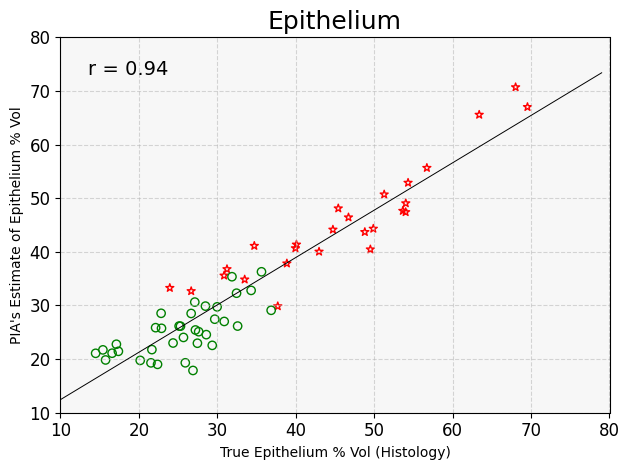

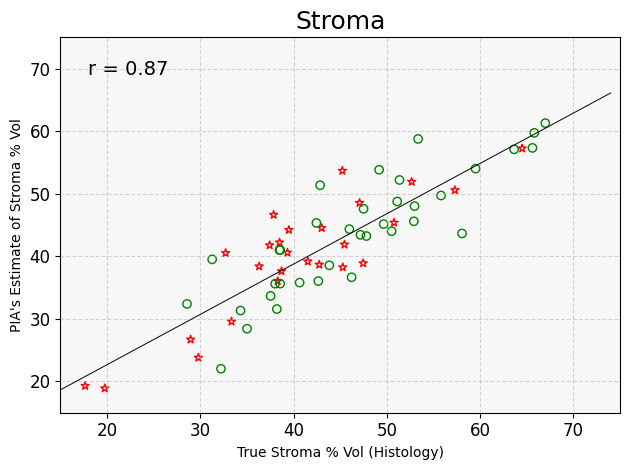

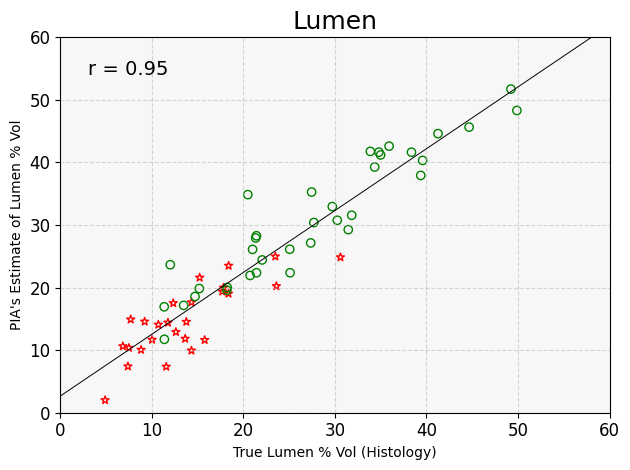

In [66]:
df_cancer = df[df.tissue == 'cancer']
df_healthy = df[df.tissue != 'cancer']
plt.scatter(list(df_cancer.ep_vol_pat), list(df_cancer.ep_vol_pia), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.ep_vol_pat), list(df_healthy.ep_vol_pia), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Epithelium % Vol (Histology)')
plt.ylabel('PIA\'s Estimate of Epithelium % Vol')
plt.title('Epithelium', fontsize=18)
xmin = 10
xmax = 80
samples = np.arange(xmin,xmax)
slope, intercept, _, _, _ = linregress(list(df.ep_vol_pat), list(df.ep_vol_pia))
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.ep_vol_pat), list(df.ep_vol_pia))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


plt.scatter(list(df_cancer.st_vol_pat), list(df_cancer.st_vol_pia), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.st_vol_pat), list(df_healthy.st_vol_pia), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Stroma % Vol (Histology)')
plt.ylabel('PIA\'s Estimate of Stroma % Vol')
plt.title('Stroma', fontsize=18)
xmin = 15
xmax = 75
samples = np.arange(xmin,xmax)
slope, intercept, r_value, _, _ = linregress(list(df.st_vol_pat), list(df.st_vol_pia))
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.st_vol_pat), list(df.st_vol_pia))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

plt.scatter(list(df_cancer.lu_vol_pat), list(df_cancer.lu_vol_pia), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.lu_vol_pat), list(df_healthy.lu_vol_pia), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Lumen % Vol (Histology)')
plt.ylabel('PIA\'s Estimate of Lumen % Vol')
plt.title('Lumen', fontsize=18)
xmin = 0
xmax = 60
samples = np.arange(xmin,xmax)
slope, intercept, r_value, _, _ = linregress(list(df.lu_vol_pat), list(df.lu_vol_pia))
trendline = [(slope * xi) + intercept for xi in samples]
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.lu_vol_pat), list(df.lu_vol_pia))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

# Volume Estimates of Hybrid vs Histology

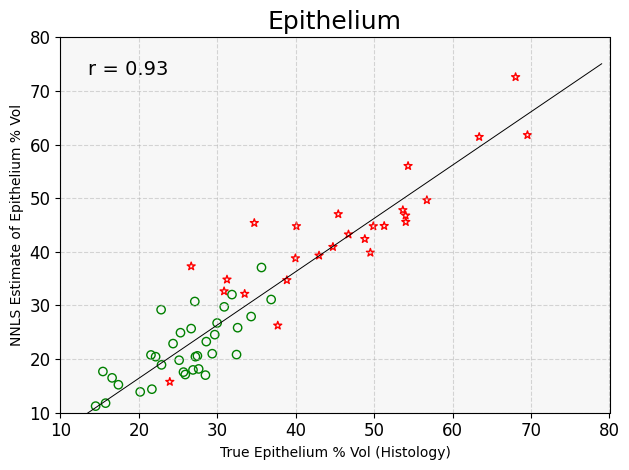

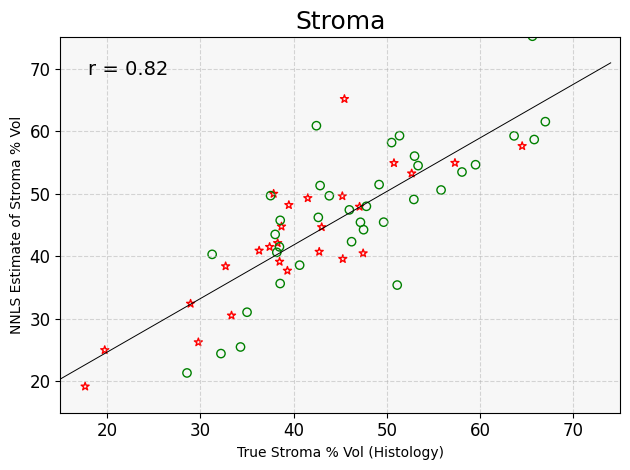

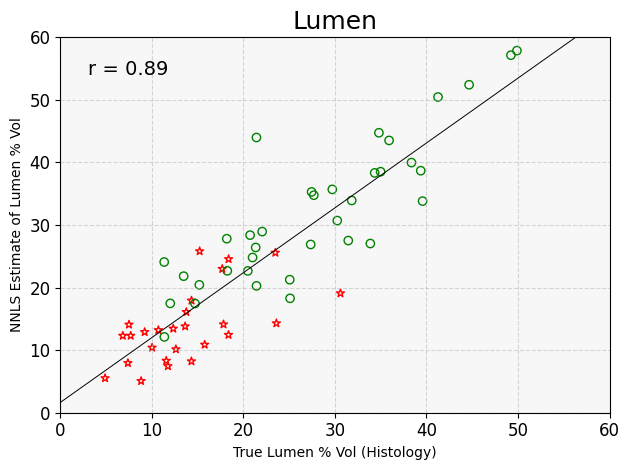

In [67]:
df_cancer = df[df.tissue == 'cancer']
df_healthy = df[df.tissue != 'cancer']
plt.scatter(list(df_cancer.ep_vol_pat), list(df_cancer.ep_vol_hybrid), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.ep_vol_pat), list(df_healthy.ep_vol_hybrid), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Epithelium % Vol (Histology)')
plt.ylabel('NNLS Estimate of Epithelium % Vol')
plt.title('Epithelium', fontsize=18)
xmin = 10
xmax = 80
samples = np.arange(xmin,xmax)
slope, intercept, _, _, _ = linregress(list(df.ep_vol_pat), list(df.ep_vol_hybrid))
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.ep_vol_pat), list(df.ep_vol_hybrid))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


plt.scatter(list(df_cancer.st_vol_pat), list(df_cancer.st_vol_hybrid), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.st_vol_pat), list(df_healthy.st_vol_hybrid), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Stroma % Vol (Histology)')
plt.ylabel('NNLS Estimate of Stroma % Vol')
plt.title('Stroma', fontsize=18)
xmin = 15
xmax = 75
samples = np.arange(xmin,xmax)
slope, intercept, r_value, _, _ = linregress(list(df.st_vol_pat), list(df.st_vol_hybrid))
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.st_vol_pat), list(df.st_vol_hybrid))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

plt.scatter(list(df_cancer.lu_vol_pat), list(df_cancer.lu_vol_hybrid), facecolors='none', edgecolors='r', marker='*')
plt.scatter(list(df_healthy.lu_vol_pat), list(df_healthy.lu_vol_hybrid), facecolors='none', edgecolors='g', marker='o')
plt.xlabel('True Lumen % Vol (Histology)')
plt.ylabel('NNLS Estimate of Lumen % Vol')
plt.title('Lumen', fontsize=18)
xmin = 0
xmax = 60
samples = np.arange(xmin,xmax)
slope, intercept, r_value, _, _ = linregress(list(df.lu_vol_pat), list(df.lu_vol_hybrid))
trendline = [(slope * xi) + intercept for xi in samples]
trendline = [(slope * xi) + intercept for xi in samples]
r_pia = round(pearsonr(list(df.lu_vol_pat), list(df.lu_vol_hybrid))[0], 2)
plt.plot(samples, trendline, color='k', linestyle='-', linewidth=0.7)
plt.text(0.05, 0.9, f'r = {r_pia:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

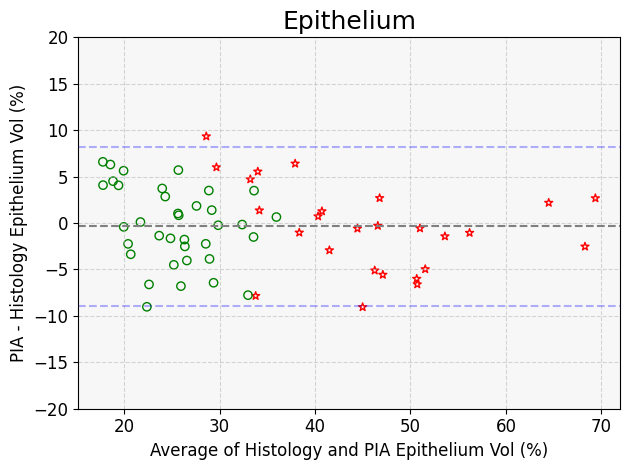

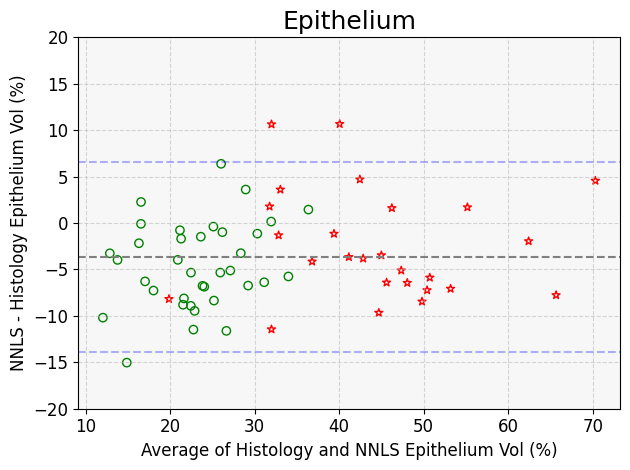

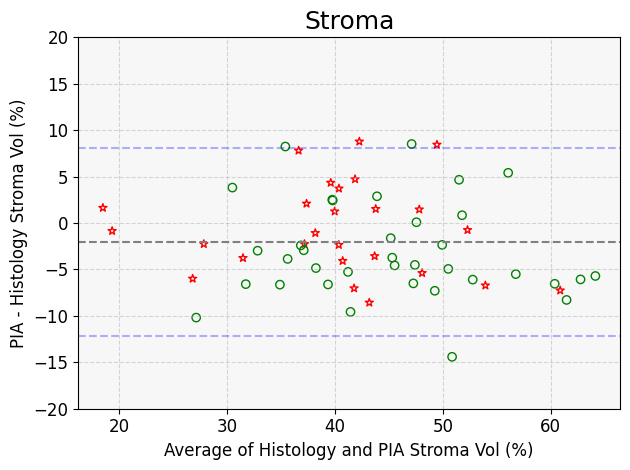

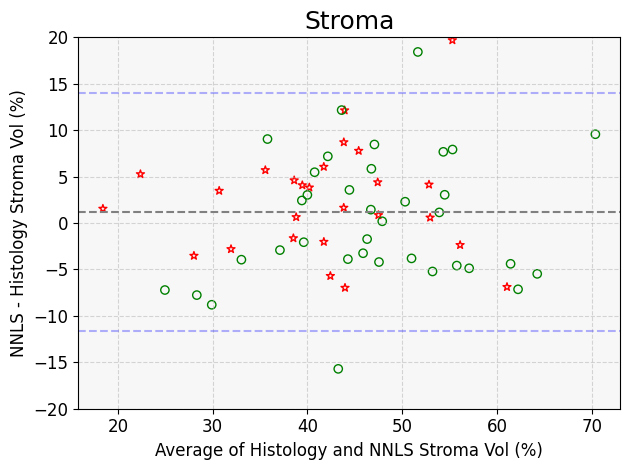

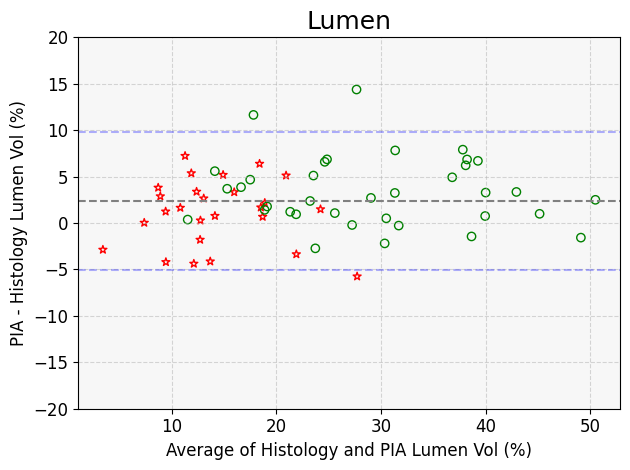

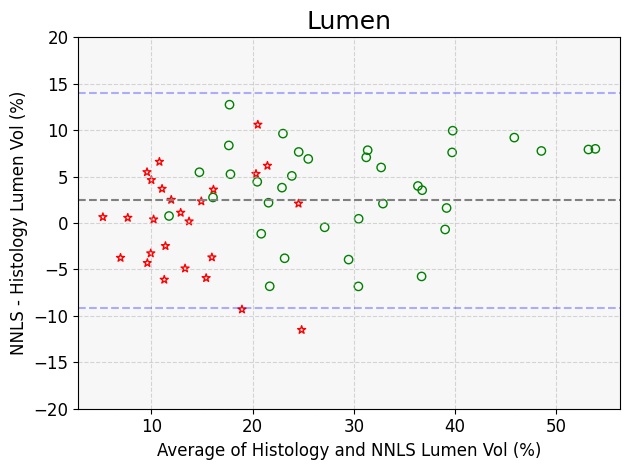

In [68]:



def bland_altman_plot(df, data_true, data_estimated, model):

    if data_estimated.startswith('ep'):
        tissue = 'Epithelium'
    elif data_estimated.startswith('st'):
        tissue = 'Stroma'
    else:
        tissue = 'Lumen'

    df_cancer = df[df.tissue == 'cancer']
    df_healthy = df[df.tissue != 'cancer']

    cancer_data_true = np.asarray(df_cancer[data_true])
    cancer_data_estimated = np.asarray(df_cancer[data_estimated])

    healthy_data_true = np.asarray(df_healthy[data_true])
    healthy_data_estimated = np.asarray(df_healthy[data_estimated])

    data_true     = np.concatenate((cancer_data_true, healthy_data_true))
    data_estimated     = np.concatenate((cancer_data_estimated, healthy_data_estimated))

    diff      = data_estimated - data_true      # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(np.mean([cancer_data_true, cancer_data_estimated], axis=0),  cancer_data_estimated - cancer_data_true, facecolors='none', edgecolors='r', marker='*')
    plt.scatter(np.mean([healthy_data_true, healthy_data_estimated], axis=0),  healthy_data_estimated - healthy_data_true, facecolors='none', edgecolors='g', marker='o')
    plt.xlabel(f'Average of Histology and {model} {tissue} Vol (%)', fontsize=12)
    plt.ylabel(f'{model} - Histology {tissue} Vol (%)', fontsize=12)
    plt.title(tissue, fontsize=18)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='blue', alpha=0.3, linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', alpha=0.3, linestyle='--')
    plt.ylim(-20,20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_facecolor('#f7f7f7')
    plt.tight_layout()


bland_altman_plot(df, 'ep_vol_pat', 'ep_vol_pia', 'PIA')
plt.figure()
bland_altman_plot(df, 'ep_vol_pat', 'ep_vol_hybrid', 'NNLS')
plt.figure()
bland_altman_plot(df, 'st_vol_pat', 'st_vol_pia', 'PIA')
plt.figure()
bland_altman_plot(df, 'st_vol_pat', 'st_vol_hybrid', 'NNLS')
plt.figure()

bland_altman_plot(df, 'lu_vol_pat', 'lu_vol_pia', 'PIA')
plt.figure()
bland_altman_plot(df, 'lu_vol_pat', 'lu_vol_hybrid', 'NNLS')